Goal: compare policy transaction and zendesk tickets to understand broker frustrations.  
Assumption: tickets created soon after a transaction are related to that transaction.
- merge policy transactions with tickets on account number
- look at tickets that occur after defined window after transaction
- differentiate between new and experienced brokers

In [1]:
import pandas as pd
import os
import sqlalchemy

from attU.sql import psql_load
from attU.dfclean import convert_dates

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
matplotlib.rcParams.update({'font.size': 15})

In [5]:
attune_dw_host = os.getenv("ATTUNE_DW_HOST")
attune_dw_user = os.getenv("ATTUNE_DW_USER")
attune_dw_db = os.getenv("ATTUNE_DW_DB", "attune_dw")

In [6]:
# Hit rate query, number of tickets from produders vs all 
query = r"""
with merged as (
    with zd as (
        select case
                   when t.inquiry_type in ('about_attune', 'general_inquiries', 'general_inquiry',
                                           'miscellaneous_na', 'technical_support', 'voicemails',
                                           'commission_inquiries', 'binding_moratorium',
                                           'intuit_support', 'claim_inquiries') then 'General'
                   when t.inquiry_type in
                        ('coverage_inquiries', 'coverage_inquiries_', 'eligibility')
                       then 'Coverage/Eligibility'
                   when t.inquiry_type in ('quote_changes') then 'Quote change'
                   when t.inquiry_type in ('bind_requests', 'policy_issuance', 'policy_issuance_')
                       then 'Issuance'
                   when t.inquiry_type in ('endorsement_non_premium_bearing', 'endorsements')
                       then 'Policy change'
                   when t.inquiry_type in ('agent_cancellation', 'cancellations')
                       then 'Cancellation'
                   when t.inquiry_type in ('reinstatement_request') then 'Reinstatement'
                   when t.inquiry_type in ('renewal_indication', 'renewals') then 'Renewals'
                   when t.inquiry_type in ('billing_inquiries', 'collections') then 'Billing'
                   when t.inquiry_type in ('underwriting_audit') then 'UW Audit'
                   when t.inquiry_type in ('loss_runs', 'document_requests', 'document_requested')
                       then 'Documents'
                   when t.inquiry_type in ('wc', 'workers_compensation') then 'Workers Comp'
                   else 'General' end  as inquiry_type
             , via_channel
             , ticket_id
             , created_at::timestamp
             , case
                   when t.account_number ~ '\D' then null
                   else t.account_number end as account_number
             , tags
        from zendesk_tickets t
    )

    select p.producer_code,
           p.account_number,
           p.transaction_type,
           p.transaction_close_date::timestamp,
           p.product_type,
           zd.*
    from bi.policy_transactions p
             left join zd on p.account_number = zd.account_number
),

zd_merged as (
select created_at::date date, count(distinct(ticket_id)) producer_tickets
from merged m
group by 1
),

zd_all as (
    select z.created_at::date date, count(distinct(ticket_id)) all_tickets
    from zendesk_tickets z
    group by 1
)

--hit rate, see coverage by producer code type and time
select zd_all.date zdate, all_tickets, producer_tickets
from zd_all
left join zd_merged on zd_all.date = zd_merged.date
"""

In [7]:
# retrieve from dw
df = psql_load(query)

In [10]:
df = df.fillna(0)

In [23]:
df['zdate'] = pd.to_datetime(df.zdate)

Tickets that can be tied to a producer code via account number

<IPython.core.display.Javascript object>


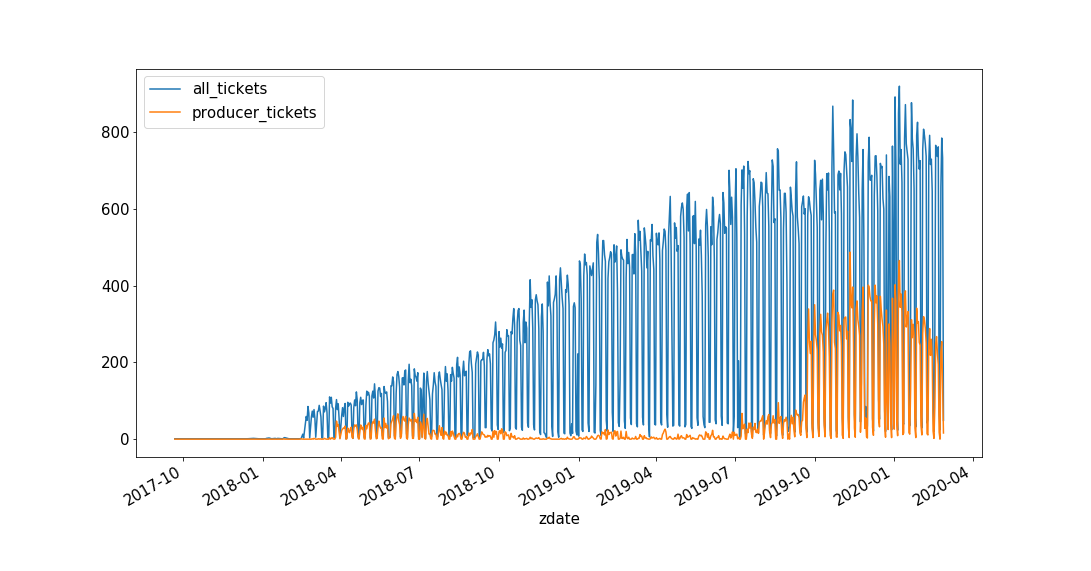

In [36]:
df.plot('zdate', ['all_tickets','producer_tickets'])

As a percentage

In [32]:
# df.head()
df['ratio'] = df.producer_tickets/df.all_tickets

<IPython.core.display.Javascript object>


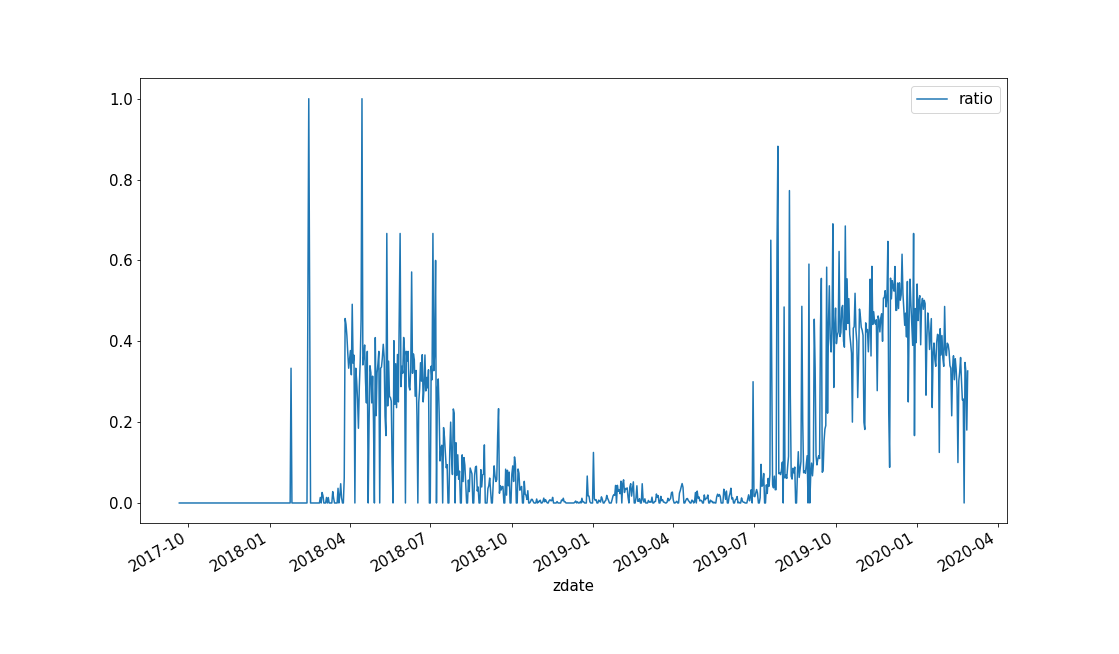

In [37]:
df.plot('zdate', 'ratio')

In [198]:
#Just timeseries data
query = r"""
with zd as (
        select case
                   when t.inquiry_type in ('about_attune', 'general_inquiries', 'general_inquiry',
                                           'miscellaneous_na', 'technical_support', 'voicemails',
                                           'commission_inquiries', 'binding_moratorium',
                                           'intuit_support', 'claim_inquiries') then 'General'
                   when t.inquiry_type in
                        ('coverage_inquiries', 'coverage_inquiries_', 'eligibility')
                       then 'Coverage/Eligibility'
                   when t.inquiry_type in ('quote_changes') then 'Quote change'
                   when t.inquiry_type in ('bind_requests', 'policy_issuance', 'policy_issuance_')
                       then 'Issuance'
                   when t.inquiry_type in ('endorsement_non_premium_bearing', 'endorsements')
                       then 'Policy change'
                   when t.inquiry_type in ('agent_cancellation', 'cancellations')
                       then 'Cancellation'
                   when t.inquiry_type in ('reinstatement_request') then 'Reinstatement'
                   when t.inquiry_type in ('renewal_indication', 'renewals') then 'Renewals'
                   when t.inquiry_type in ('billing_inquiries', 'collections') then 'Billing'
                   when t.inquiry_type in ('underwriting_audit') then 'UW Audit'
                   when t.inquiry_type in ('loss_runs', 'document_requests', 'document_requested')
                       then 'Documents'
                   when t.inquiry_type in ('wc', 'workers_compensation') then 'Workers Comp'
                   else 'General' end  as inquiry_type
             , via_channel
             , ticket_id
             , created_at::timestamp
             , case
                   when t.account_number ~ '\D' then null
                   else t.account_number end as account_number
             , tags
        from zendesk_tickets t
    )

    select p.producer_code,
           p.transaction_type,
           p.transaction_close_date::timestamp t_date,
           p.product_type,
           zd.inquiry_type, zd.via_channel, zd.ticket_id,
           zd.created_at, zd.account_number,
           string_to_array(trim(both '[]' from zd.tags), ', ') as tag
    from bi.policy_transactions p
    inner join zd on p.account_number = zd.account_number
    where p.transaction_close_date > '2019-09-30 23:59:59';
"""

In [199]:
df = psql_load(query)
# df = pd.read_csv('producer_ticket_metrics.csv')

In [8]:
# df.to_csv('producer_ticket_metrics.csv', index=False)

//anaconda3/envs/zendesk/lib/python3.7/site-packages/s3fs/mapping.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping


Policy transactions in the last 6 months (before join to ZD)
- 35931 transactions 3/2/2020
- 31501 for distinct transaction dates  
- select count(distinct(transaction_close_date)) from bi.policy_transactions
where transaction_close_date > '2019-09-30 23:59:59';

Joined to ZD sample

In [200]:
df.head()

producer_code transaction_type                  t_date product_type  \
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
1    TRAZA00001    reinstatement 2019-11-04 18:05:14.134          BOP   
2    PINKH00001      endorsement 2019-10-03 22:39:12.739          BOP   
3    PINKH00001     new business 2019-10-03 18:57:40.985          BOP   
4    PINKH00001    reinstatement 2019-11-06 00:00:00.000           WC   

  inquiry_type via_channel ticket_id          created_at account_number  \
0      General         api    133665 2019-08-15 16:19:05     5948877397   
1      General         api    133665 2019-08-15 16:19:05     5948877397   
2      General         web    157500 2019-10-09 16:05:09     7396665544   
3      General         web    157500 2019-10-09 16:05:09     7396665544   
4      General         web    157500 2019-10-09 16:05:09     7396665544   

                                                 tag  
0  ['3rd_party_inaccurate', 'bop', 'class_disagre...  
1  ['3rd_party_inaccurate', 'bop', 'class_disagre...  
2  ['broker_outreach', 'email_1', 'source_interna...  
3  ['broker_outreach', 'email_1', 'source_interna...  
4  ['broker_outreach', 'email_1', 'source_interna...

Distinct transaction dates after join to ZD

In [202]:
df.t_date.unique().size

21699

2/3 of policy transaction producer-account number pairs have created a ticket

In [ ]:
#transaction ts time series stats

In [51]:
import numpy as np

In [132]:
def get_timestamp_diff_stats(dates):
    udates = np.unique(dates)
    if len(udates)>1:
        diffs = np.diff(np.sort(udates))
#         return (min(diffs), max(diffs), np.mean(diffs))
#         return dict({'min': min(diffs), 
#                 'max': max(diffs), 
#                 'mean': np.mean(diffs)})
        return min(diffs)
    return None

In [190]:
# df.dropna(subset=['ticket_id']).head(4)

In [140]:
mins = df.dropna(subset=['ticket_id']).groupby(['producer_code','account_number'])['transaction_close_date'].\
apply(lambda x: get_timestamp_diff_stats(x.values))

In [203]:
# mins.sort_values()

In [ ]:
#transactions can occur simutaneously

In [191]:
# df[(df.producer_code=='MORSTAN00001') & (df.account_number=='6821901809')].head()

In [204]:
import datetime as dt

In [205]:
def is_cotemporal(ts1: pd.Timestamp, ts2: pd.Timestamp, days_before=0, days_after=1):
    td_before = dt.timedelta(days=days_before)
    td_after = dt.timedelta(days=days_after)
    diff = ts2 - ts1
    if diff.value <= 0 and abs(diff)<=td_before:
        return True
    if diff.value >=0 and diff<=td_after:
        return True
    return False

In [212]:
#add bool cols for various windows
for db, da in [(1, 1), (0, 1), (0, 2), (0, 7), (0, 14), (0, 30)]:
    col_name = f"ct_{db}{da}"
    df[col_name] = df.apply(lambda x: is_cotemporal(
        x['t_date'], x['created_at'], days_before=db, days_after=da),
        axis=1)

Compare transaction date and ticket creation dates

In [213]:
df.head()

producer_code transaction_type                  t_date product_type  \
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
1    TRAZA00001    reinstatement 2019-11-04 18:05:14.134          BOP   
2    PINKH00001      endorsement 2019-10-03 22:39:12.739          BOP   
3    PINKH00001     new business 2019-10-03 18:57:40.985          BOP   
4    PINKH00001    reinstatement 2019-11-06 00:00:00.000           WC   

  inquiry_type via_channel ticket_id          created_at account_number  \
0      General         api    133665 2019-08-15 16:19:05     5948877397   
1      General         api    133665 2019-08-15 16:19:05     5948877397   
2      General         web    157500 2019-10-09 16:05:09     7396665544   
3      General         web    157500 2019-10-09 16:05:09     7396665544   
4      General         web    157500 2019-10-09 16:05:09     7396665544   

                                                 tag  ct_11  ct_01  ct_02  \
0  ['3rd_party_inaccurate', 'bop', 'class_disagre...  False  False  False   
1  ['3rd_party_inaccurate', 'bop', 'class_disagre...  False  False  False   
2  ['broker_outreach', 'email_1', 'source_interna...  False  False  False   
3  ['broker_outreach', 'email_1', 'source_interna...  False  False  False   
4  ['broker_outreach', 'email_1', 'source_interna...  False  False  False   

   ct_07  ct_014  ct_030  
0  False   False   False  
1  False   False   False  
2   True    True    True  
3   True    True    True  
4  False   False   False

Explode tags

In [214]:
#explode tags
df = df.explode('tag')

In [216]:
df.drop_duplicates(inplace=True)

In [227]:
df['tag'] = df.tag.str.strip("''")

In [228]:
df.head()

producer_code transaction_type                  t_date product_type  \
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0    TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   

  inquiry_type via_channel ticket_id          created_at account_number  \
0      General         api    133665 2019-08-15 16:19:05     5948877397   
0      General         api    133665 2019-08-15 16:19:05     5948877397   
0      General         api    133665 2019-08-15 16:19:05     5948877397   
0      General         api    133665 2019-08-15 16:19:05     5948877397   
0      General         api    133665 2019-08-15 16:19:05     5948877397   

                       tag  ct_11  ct_01  ct_02  ct_07  ct_014  ct_030  
0     3rd_party_inaccurate  False  False  False  False   False   False  
0                      bop  False  False  False  False   False   False  
0       class_disagreement  False  False  False  False   False   False  
0         no_action_needed  False  False  False  False   False   False  
0  research_exonerates_yes  False  False  False  False   False   False

Case: Most common Billing frustrations after binds?

In [246]:
dfb = df[(df.transaction_type == 'new business') & (df.inquiry_type == 'Billing')].copy()

In [247]:
dfb.reset_index(drop=True, inplace=True)

Restricted dataset stats:

In [256]:
for col in ['t_date','producer_code', 'ticket_id']:
    print(f"Unique number of {col}s: {dfb[col].unique().size}")

Unique number of t_dates: 2844
Unique number of producer_codes: 675
Unique number of ticket_ids: 3921


In [288]:
#sell tags of interest
raw = '''payment_confirmation	341
payment_history_schedule_request	262
collections	259
billing_process	252
commission_inquiries	234
billing_center_change_paymentplan	156
invoice_request	156
updaed_insured_email	133
no_known_loss_requested	129
stripe_unenroll_autopay	103
refund_process	86
commission_inquiry	84
q4incentive	84
billing_center_instructions	83
check_request	82
automatic_payment_status	70
stripe_change_paymentmethod	65
automatic_payment_instructions	43
reinstatement_approved	38
commission_statement	30
billing_center_update_downpayment	29
update_agent_email	19
update_commission_account	15
change_email	14
renewal_indication	14
renewal_issuance	13
2_4_pay_inquiry	12
bop	11
cancellation_confirmation	11
payment_viaphone_request	10
policy_issuance_	10
policy_issuance_request	10
siaa	10
broker_cancel_request	9
check_confirmation	9
'''

In [289]:
sell_tags = raw.replace('\t',' ').replace('\n',' ').split()[::2]

In [287]:
#sanity check
# dfb[(dfb['ct_01']) & (dfb.tag=='phone_followup')]

Restrict to relevant tags and check coverage

In [296]:
dfb['rtag'] = dfb.tag.isin(sell_tags)

In [305]:
dfr = dfb[dfb.rtag].copy()

In [306]:
dfr.head(2)

producer_code transaction_type                  t_date product_type  \
1   MORSTAN00001     new business 2019-10-01 19:52:05.537          BOP   
5  TAOGLONY00001     new business 2019-10-16 14:54:11.896          BOP   

  inquiry_type via_channel ticket_id          created_at account_number  \
1      Billing       email    155636 2019-10-04 17:16:52     5439886296   
5      Billing        chat    160538 2019-10-16 15:02:50     2597369230   

                                tag  ct_11  ct_01  ct_02  ct_07  ct_014  \
1  payment_history_schedule_request  False  False  False   True    True   
5  payment_history_schedule_request   True   True   True   True    True   

   ct_030  rtag  
1    True  True  
5    True  True

In [339]:
for col in ['t_date','producer_code', 'ticket_id']:
    print(f"Unique number of {col}s: {dfr[dfr['ct_02']][col].unique().size}")

Unique number of t_dates: 531
Unique number of producer_codes: 251
Unique number of ticket_ids: 523


Tag counts for 1 day after

In [324]:
dfr[dfr['ct_01']].groupby('tag').nunique()['ticket_id'].sort_values(ascending=False)[:10]

tag
billing_center_change_paymentplan    110
invoice_request                       79
updaed_insured_email                  67
billing_process                       57
billing_center_update_downpayment     41
payment_confirmation                  32
billing_center_instructions           31
payment_history_schedule_request      31
check_request                         19
automatic_payment_instructions        15
Name: ticket_id, dtype: int64

Tag counts for 2 days after

In [325]:
dfr[dfr['ct_02']].groupby('tag').nunique()['ticket_id'].sort_values(ascending=False)[:10]

tag
billing_center_change_paymentplan    118
invoice_request                       91
updaed_insured_email                  75
billing_process                       73
billing_center_update_downpayment     49
payment_confirmation                  37
payment_history_schedule_request      37
billing_center_instructions           34
check_request                         26
automatic_payment_instructions        19
Name: ticket_id, dtype: int64

Tag counts for 7 days after

In [392]:
dfr[dfr['ct_030']].groupby('tag').nunique()['ticket_id'].sort_values(ascending=False)[:10]

tag
billing_center_change_paymentplan    380
invoice_request                      308
payment_confirmation                 307
collections                          302
billing_process                      271
updaed_insured_email                 222
payment_history_schedule_request     175
billing_center_instructions          150
check_request                        119
billing_center_update_downpayment     98
Name: ticket_id, dtype: int64

Issues:
- statistics get weak at the 1,2 day level (~250 producers, ~500 tickets)
- the larger the window, the weaker the assumption that the ticket is related to that specific bind transaction.

In [366]:
#most used channel by producer
# dfb.groupby(['producer_code','via_channel']).nunique()['ticket_id'].\
# reset_index().sort_values(['producer_code','ticket_id'], ascending=False).groupby('producer_code').first().head(50)

Number of unique transactions by producer code & account number over all time

In [391]:
df.groupby(['producer_code','account_number']).nunique()['t_date'].value_counts()

1     7076
2     3860
3     1200
4      630
5      242
6      106
7       41
8       31
9       15
10      10
11       5
12       3
14       2
13       1
Name: t_date, dtype: int64

Most common ticket tags that occur 1 day after each transaction type

In [384]:
df[df['ct_01']].groupby(['transaction_type','inquiry_type','tag']).nunique()['ticket_id'].\
reset_index().sort_values(['transaction_type','ticket_id'], ascending=False).groupby('transaction_type').head(5)

transaction_type   inquiry_type                              tag  \
1445               rewrite        Billing                billing_inquiries   
1450               rewrite        Billing                     inbound_call   
1467               rewrite        General                              bop   
1480               rewrite        General                     severity_low   
1486               rewrite        General                        uw_alerts   
1438            rescission   Workers Comp                               wc   
1441            rescission   Workers Comp                     workers_comp   
1430            rescission        Billing                billing_inquiries   
1431            rescission        Billing                     inbound_call   
1432            rescission        Billing             payment_confirmation   
1417               renewal       Renewals                         renewals   
1413               renewal       Renewals               renewal_indication   
1415               renewal       Renewals                 renewal_issuance   
1188               renewal        Billing                billing_inquiries   
1426               renewal       Renewals                              vip   
1079         reinstatement        Billing                billing_inquiries   
1116         reinstatement   Cancellation                    cancellations   
1115         reinstatement   Cancellation              cancellation_notice   
1122         reinstatement   Cancellation                       nonpayment   
1125         reinstatement   Cancellation                   outbound_email   
1069  pending cancellation   Workers Comp                               wc   
1072  pending cancellation   Workers Comp                     workers_comp   
1048  pending cancellation        Billing                billing_inquiries   
1049  pending cancellation        Billing             updaed_insured_email   
1050  pending cancellation        General                        beta_full   
710           new business        General                              bop   
787           new business        General                        uw_alerts   
753           new business        General                 no_action_needed   
773           new business        General                     severity_low   
727           new business        General             contacted_broker_yes   
419            endorsement  Policy change                     endorsements   
225            endorsement        Billing                billing_inquiries   
416            endorsement  Policy change  endorsement_non_premium_bearing   
329            endorsement        General                              bop   
395            endorsement  Policy change               additional_insured   
16            cancellation        Billing                billing_inquiries   
35            cancellation        Billing                     inbound_call   
72            cancellation   Cancellation                    cancellations   
38            cancellation        Billing          no_known_loss_requested   
48            cancellation        Billing           reinstatement_approved   
0                    audit  Policy change                 attune_insurance   
1                    audit  Policy change                        beta_full   
2                    audit  Policy change                             bump   
3                    audit  Policy change                      bump_solved   
4                    audit  Policy change                 coverage_inquiry   

      ticket_id  
1445         12  
1450          6  
1467          6  
1480          5  
1486          5  
1438          3  
1441          2  
1430          1  
1431          1  
1432          1  
1417        498  
1413        488  
1415        484  
1188        155  
1426         49  
1079         33  
1116         28  
1115         16  
1122         16  
1125         12  
1069          4  
1072          2  
1048   

Next up:
- get most relevant ticket tags for every transaction type
- check transactions by producer code-account per month (count, time btwn transactions)
- Look at new vs experienced brokers

In [386]:
# df[df['ct_01']].groupby(['transaction_type','inquiry_type','tag']).nunique()['ticket_id'].\
# reset_index().nlargest(3,['transaction_type','ticket_id'])

In [221]:
import seaborn as sns

//anaconda3/envs/zendesk/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [341]:
df

producer_code transaction_type                  t_date product_type  \
0        TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0        TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0        TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0        TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
0        TRAZA00001     cancellation 2019-10-22 08:10:06.635          BOP   
...             ...              ...                     ...          ...   
67339    APPUND0001     cancellation 2020-02-15 18:23:53.931          BOP   
67340     FLIMSAIS1     new business 2019-11-05 16:26:52.809          BOP   
67340     FLIMSAIS1     new business 2019-11-05 16:26:52.809          BOP   
67340     FLIMSAIS1     new business 2019-11-05 16:26:52.809          BOP   
67340     FLIMSAIS1     new business 2019-11-05 16:26:52.809          BOP   

       inquiry_type via_channel ticket_id          created_at account_number  \
0           General         api    133665 2019-08-15 16:19:05     5948877397   
0           General         api    133665 2019-08-15 16:19:05     5948877397   
0           General         api    133665 2019-08-15 16:19:05     5948877397   
0           General         api    133665 2019-08-15 16:19:05     5948877397   
0           General         api    133665 2019-08-15 16:19:05     5948877397   
...             ...         ...       ...                 ...            ...   
67339       Billing       email    221595 2020-02-16 01:22:54     8282630341   
67340  Cancellation         web    211683 2020-01-28 23:04:38     3634334865   
67340  Cancellation         web    211683 2020-01-28 23:04:38     3634334865   
67340  Cancellation         web    211683 2020-01-28 23:04:38     3634334865   
67340  Cancellation         web    211683 2020-01-28 23:04:38     3634334865   

                                         tag  ct_11  ct_01  ct_02  ct_07  \
0                       3rd_party_inaccurate  False  False  False  False   
0                                        bop  False  False  False  False   
0                         class_disagreement  False  False  False  False   
0                           no_action_needed  False  False  False  False   
0                    research_exonerates_yes  False  False  False  False   
...                                      ...    ...    ...    ...    ...   
67339                         refund_process   True   True   True   True   
67340                  broker_cancel_request  False  False  False  False   
67340  cancellation_additional_info_required  False  False  False  False   
67340     cancellation_request_business_sold  False  False  False  False   
67340                          cancellations  False  False  False  False   

       ct_014  ct_030  
0       False   False  
0       False   False  
0       False   False  
0       False   False  
0       False   False  
...       ...     ...  
67339    True    True  
67340   False   False  
67340   False   False  
67340   False   False  
67340   False   False  

[277550 rows x 16 columns]

<IPython.core.display.Javascript object>


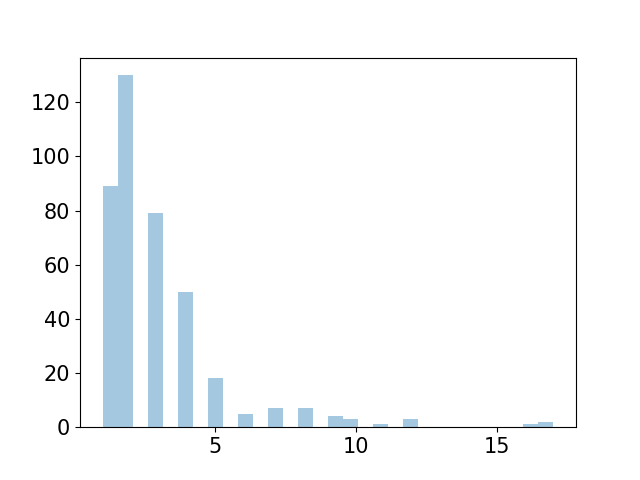

In [245]:
sns.distplot(
oa.groupby('ticket_id').count()['transaction_type'].sort_values(ascending=False).values,
    kde=False
)

Ticket Inquiry types that occurr within 7 days of transaction type

In [382]:
s = oa.groupby(['transaction_type', 'inquiry_type']).count()['producer_code']
s.reset_index().sort_values(['transaction_type','producer_code'], ascending=False)

transaction_type          inquiry_type  producer_code
64          rewrite               Billing              4
65          rewrite          Cancellation              3
68          rewrite              Issuance              2
66          rewrite  Coverage/Eligibility              1
67          rewrite               General              1
..              ...                   ...            ...
12     cancellation              Renewals              2
13     cancellation              UW Audit              2
1             audit               General              2
0             audit               Billing              1
2             audit          Workers Comp              1

[70 rows x 3 columns]

In [162]:
pd_max_context = pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [379]:
#window, products, transaction history (most recent)?, 
with pd_max_context:
    print(s.reset_index().sort_values(['transaction_type','producer_code'], ascending=False))

        transaction_type          inquiry_type  producer_code
64               rewrite               Billing              4
65               rewrite          Cancellation              3
68               rewrite              Issuance              2
66               rewrite  Coverage/Eligibility              1
67               rewrite               General              1
69               rewrite          Workers Comp              1
63            rescission          Workers Comp              3
62            rescission               General              2
57               renewal         Policy change             38
51               renewal               Billing             30
52               renewal          Cancellation             26
55               renewal               General             10
54               renewal             Documents              8
60               renewal              Renewals              6
53               renewal  Coverage/Eligibility              3
56      